In [1]:
%matplotlib inline

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

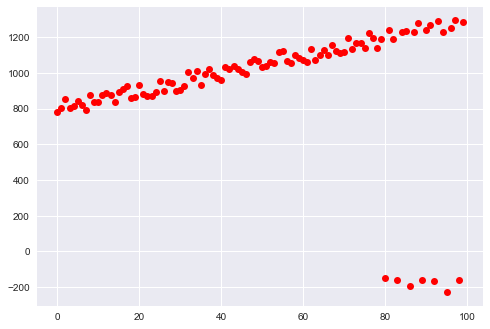

In [28]:
noiseSize = 50
size = 100

sample = np.arange(size*2).reshape( (2, size) )
sample[1] = 5 * sample[0] + 800
# sample[1][0] = 0

# add outliers!
for i in range(size - int(size/5), size, 3):
    sample[1][i] = -200
    
sample[1] = sample[1] + (np.random.rand(1,size) - .5) * noiseSize*2
sample = sample.T

plt.plot(sample[:,0], sample[:,1], 'ro')

In [29]:
data = sample
n = 2
m = data.shape[0]
scaleInfo = []

x = data[:, :n-1]
x = np.concatenate((np.ones((1,m)), x.T)).T

for i in range(0, n):
    scaleInfo.append( [ x[:,i].min(), x[:,i].mean(), x[:,i].max()] )
    
for i in range(1, n):
    for j in range(0, m):
        r = scaleInfo[i][2] - scaleInfo[i][0]
        if r != 0:
            x[j][i] = ( x[j][i] - scaleInfo[i][1] ) / r
        else:
            x[j][i] = ( x[j][i] - scaleInfo[i][1] ) / 1

y = np.array( data[:,-1] )
y = y.T

# print(x)

theta: [ 945.49423038   23.90541689]


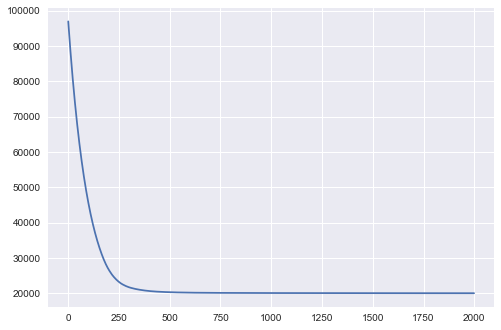

In [30]:
autoAlphaSelect = False
iterCount = 2000
alpha = 0.01
theta = np.array(n * [0])

j = []
complete = False

while( not complete ):
    complete = True
    for _ in range(0, iterCount):
        h = np.dot(x , theta)
        loss = h - y
        gradient = np.dot(loss , x)
        theta = theta - alpha / m * gradient
        j += [ abs(np.array(loss)).sum() ]
        
        for i in range(0,n):
            theta[i] = theta[i] - (alpha / m * x[:,1].dot(loss))
        
        # fix big alpha
        if ( autoAlphaSelect and j[ len(j)-1 ] > j[ len(j)-2 ]):
            complete = False
            alpha = alpha / 10
            print('alpha:', alpha)
            theta = np.array(n * [0])
            j.clear()
            break

print('theta:', theta )
plt.plot(j)

(0, 933.54152193250945) (99, 957.44693882231616)


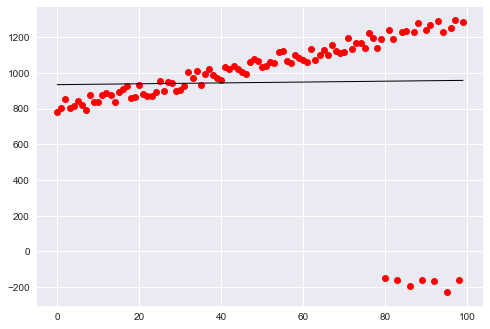

In [31]:
def scale(a, scaleInfo):
    result = [1]
    for i in range(1, n):
        r = scaleInfo[i][2] - scaleInfo[i][0]
        if r != 0:
            result += [( a[i-1] - scaleInfo[i][1] ) / r]
        else:
            result += [( a[i-1] - scaleInfo[i][1] ) / 1]
    return result

a = (0, np.array(scale([0], scaleInfo)).dot(theta))
b = (m-1, np.array(scale([m-1], scaleInfo)).dot(theta))

print( a, b)
            
plt.plot(sample[:,0], sample[:,1], 'ro')
plt.plot([ a[0], b[0] ], [ a[1], b[1] ], 'k-', lw=1)

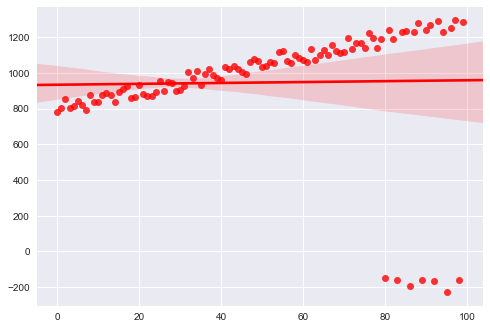

In [32]:
sns.regplot(sample[:,0], sample[:,1], color='red')

In [44]:
def generate_data(t, A, sigma, omega, noise=0, n_outliers=0, random_state=0):
    y = A * np.exp(-sigma * t) * np.sin(omega * t)
    rnd = np.random.RandomState(random_state)
    error = noise * rnd.randn(t.size)
    outliers = rnd.randint(0, t.size, n_outliers)
    error[outliers] *= 35
    return y + error

def fun(x, t, y):
    return x[0] * np.exp(-x[1] * t) * np.sin(x[2] * t) - y

In [45]:
A = 2
sigma = 0.1
omega = 0.1 * 2 * np.pi
x_true = np.array([A, sigma, omega])

noise = 0.1

t_min = 0
t_max = 30

x0 = np.ones(3)
t_train = np.linspace(t_min, t_max, 30)
y_train = generate_data(t_train, A, sigma, omega, noise=noise, n_outliers=4)

res_robust = least_squares(fun, x0, loss='soft_l1', f_scale=0.1, args=(t_train, y_train))

In [55]:
y_lsq = generate_data(t_test, *res_lsq.x)
y_robust = generate_data(t_test, *res_robust.x)

plt.plot(t_train, y_train, 'o', label='data')
plt.plot(res_robust)
plt.xlabel('$t$')
plt.ylabel('$y$')

NameError: name 't_test' is not defined

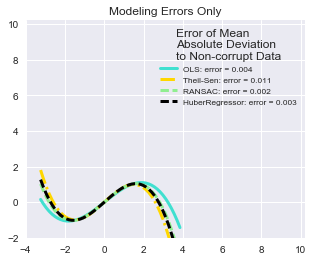

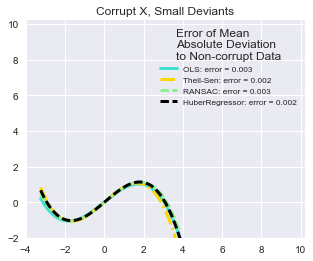

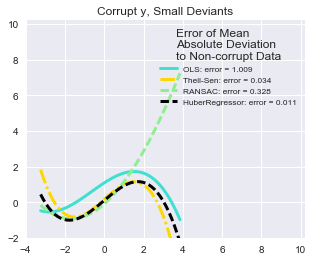

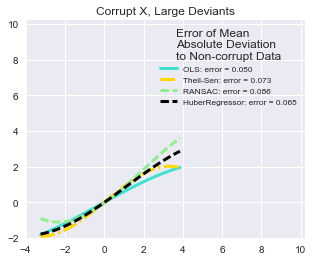

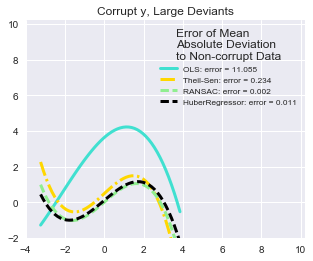

In [56]:
from matplotlib import pyplot as plt
import numpy as np

from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

np.random.seed(42)

X = np.random.normal(size=400)
y = np.sin(X)
# Make sure that it X is 2D
X = X[:, np.newaxis]

X_test = np.random.normal(size=200)
y_test = np.sin(X_test)
X_test = X_test[:, np.newaxis]

y_errors = y.copy()
y_errors[::3] = 3

X_errors = X.copy()
X_errors[::3] = 3

y_errors_large = y.copy()
y_errors_large[::3] = 10

X_errors_large = X.copy()
X_errors_large[::3] = 10

estimators = [('OLS', LinearRegression()),
              ('Theil-Sen', TheilSenRegressor(random_state=42)),
              ('RANSAC', RANSACRegressor(random_state=42)),
              ('HuberRegressor', HuberRegressor())]
colors = {'OLS': 'turquoise', 'Theil-Sen': 'gold', 'RANSAC': 'lightgreen', 'HuberRegressor': 'black'}
linestyle = {'OLS': '-', 'Theil-Sen': '-.', 'RANSAC': '--', 'HuberRegressor': '--'}
lw = 3

x_plot = np.linspace(X.min(), X.max())
for title, this_X, this_y in [
        ('Modeling Errors Only', X, y),
        ('Corrupt X, Small Deviants', X_errors, y),
        ('Corrupt y, Small Deviants', X, y_errors),
        ('Corrupt X, Large Deviants', X_errors_large, y),
        ('Corrupt y, Large Deviants', X, y_errors_large)]:
    plt.figure(figsize=(5, 4))
    plt.plot(this_X[:, 0], this_y, 'b+')

    for name, estimator in estimators:
        model = make_pipeline(PolynomialFeatures(3), estimator)
        model.fit(this_X, this_y)
        mse = mean_squared_error(model.predict(X_test), y_test)
        y_plot = model.predict(x_plot[:, np.newaxis])
        plt.plot(x_plot, y_plot, color=colors[name], linestyle=linestyle[name],
                 linewidth=lw, label='%s: error = %.3f' % (name, mse))

    legend_title = 'Error of Mean\nAbsolute Deviation\nto Non-corrupt Data'
    legend = plt.legend(loc='upper right', frameon=False, title=legend_title,
                        prop=dict(size='x-small'))
    plt.xlim(-4, 10.2)
    plt.ylim(-2, 10.2)
    plt.title(title)
plt.show()